# Assignment 4

### Samuel Sheehy (Student ID 18143565)

### Techniques of High Performance Computing (PHAS0102)

### MSc Scientific Computing, University College London, 2019-2020

**This Jupyter Notebook is submitted as completion of the 4th Assignment for the UCL course cited above.**

## Setup

In [1]:
import numpy as np
from scipy.sparse import coo_matrix
import matplotlib.pyplot as plt
from math import ceil
import logging

from scipy.sparse.linalg import LinearOperator, cg, spilu

import pyopencl as cl


TRUE_RESULT = 0.424011387033 # The expected answer to 12 significant figures


logger = logging.getLogger('heat')
logger.setLevel(logging.DEBUG)
if not logger.handlers:
    hdlr = logging.FileHandler('heat.log', mode='w', encoding='latin-1')
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
        

import time
class Timer:
    """
    A simple timer class to measure the execution time
    of a function (seconds) in a ```with``` block.
    Taken from module lecture notes.
    """
    def __enter__(self):
        """
        Measure time at start.
        """
        self.start = time.time()
        return self

    def __exit__(self, *args):
        """
        Measure time at end and take difference
        from start.
        """
        self.end = time.time()
        self.interval = self.end - self.start
        

def bytesize(N, dtype_str):
    """
    Returns the number of bytes that an array of element
    size N occupies
    """
    return np.dtype(dtype_str).itemsize*N


def log(f):
    try: 
        logger.info(35*'-' + 'New Run' + 35*'-')
        with Timer() as t:
            ### Exec Code
            x = f()
            ###
        logger.info(f'Total Run Time: {t.interval:.3E} s')
    except KeyboardInterrupt:
        logger.error('Keyboard Interrupt')
#         logger.emit()
    return x

## Introduction of Problem
* Intro to the problem we are solving and the Heat Equation 


## Mathematical Derivation of Numerical Scheme

* Finite difference method:

CN finite difference in spacial dimension.
$$
u_h(t, x, y) = u_h(t - \tau, x, y) -  \frac{\tau}{h^2} \left[ 4 u_h(t - \tau, x, y)
- u_h(t - \tau, x - h, y) - u_h(t - \tau, x + h, y) - u_h(t - \tau, x, y - h) - u_h(t - \tau, x, y + h) \right] + again
$$

* How I formulate this as a matrix


## My Method
* From mathematical formulation, components of calculation are: 
    - Construction of matrices A(t) and A(t+1)
    - Calculate $u_* = A(t)u(t) + [bc]$ - maybe use OpenCL kernel?
    - Solve for $u(t+1)$: $A(t+1)u(t+1) = u_* $ (CG method -  preconditioner through LU decomposition)
    - Use secant method to find answer

## Analysis
* Show influence of size of timestep and spacestep in finding correct answer
* How time completion of each section increases with system size
* Overall convergence of final solution

In [2]:
### Helper Methods ###
def is_bc(i, j, M):
    """
    Check if the given coordinates correspond to a boundary.
    """
    if i == 0 or i == M - 1:
        return True
    elif j == 0 or j == M - 1:
        return True
    else:
        return False

    
def show(b):
    """
    Display an image of the solution on the square.
    
    TODO: generalise to any BC function
    """
    # Put flattened vector back into square
    M = int(len(b)**0.5)
    p = b.reshape(M, M)
    
    # Reinclude the original boundary conditions
    p = np.pad(p, 1)
    p[:, 0] = 0  # left bc
    p[:, -1] = 0 # right bc
    p[-1, :] = 0 # top bc
    p[0, :] = 5  # bottom bc

    # Display the solution
    plt.imshow(p, origin='lower')
    plt.colorbar()
    plt.show()

In [3]:
# At: a, a, 1 - 4*a, a, a

class FivePointStencil(LinearOperator):
    """
    Apply a 5-point stencil operator to a row-wise flattened
    lattice.
    """
    _openCL_code = """
    __kernel void matvec(
            __global double *vector,
            __global double *result,
            double alpha,
            double beta,
            double gamma,
            int M
        )
        {        
        // Get Global Identifiers i.e. the row or col index
        int row_index = get_global_id(0); // offset by one to only look
        int col_index = get_global_id(1);    // at inner lattice
        
        
        // Determine boolean operators.
        // These decide if a particular term is active or not.
        int b1 = (int) (row_index + 1 != 1);   //bottom
        int b2 = (int) (row_index + 1 != M-2); //top
        int b3 = (int) (col_index + 1 != 1);   //left
        int b4 = (int) (col_index + 1 != M-2); //right
        
        int loc = row_index*(M-2) + col_index;
        
        // Do stuff
        double product = alpha*vector[loc]              // center
                         + b1*beta*vector[b1*(loc-M+2)] // bottom
                         + b2*beta*vector[b2*(loc+M-2)] // top
                         + b3*beta*vector[b3*(loc-1)]   // left
                         + b4*beta*vector[b4*(loc+1)];  // right
    
        // Output answer
        
        result[loc] = product;
        
        }
    """
    def __init__(self, alpha, beta, M):
        """
        Initialise the OpenCL kernel with the given parameters.
        
        Arguments
        ---------
        alpha:
        
        beta:
        
        boundary_function:
        
        M:
        """
        self.Mop = (M - 2)**2
        self.shape = (self.Mop, self.Mop)
        self.M = M
        self.dtype = np.dtype(np.float64)
        self.explicit = False
        self._vector_buffer = None
        self._result_buffer = None
        self.mapped_vector_buffer = None
        self.mapped_result_buffer = None
        self.alpha = alpha
        self.beta = beta
        self.c = 0
        self.offset = 0
        # Define kernel
        self._kernel = self._build_kernel()
    
    def _build_kernel(self):
        """
        Construct the kernel.
        """
        # Initialise the OpenCL environment
        self.ctx = cl.create_some_context()
        self.queue = cl.CommandQueue(self.ctx)
        self.mf = cl.mem_flags
    
        # Create the buffer to hold the vector data
        self._vector_buffer = cl.Buffer(self.ctx, self.mf.ALLOC_HOST_PTR, bytesize(self.Mop, 'double'))

        # Create buffer to hold the result
        self._result_buffer = cl.Buffer(self.ctx, self.mf.ALLOC_HOST_PTR, size=bytesize(self.Mop, 'double'))
                                
        # Build the Kernel
        prg = cl.Program(self.ctx, FivePointStencil._openCL_code)
        prg.build()
        matvec_kernel = prg.matvec
        
        # Map Buffers
        self.mapped_vector_buffer, linking_event = cl.enqueue_map_buffer(
            self.queue, self._vector_buffer, cl.map_flags.WRITE, self.offset, self.Mop, np.double
        )
        linking_event.wait()

        self.mapped_result_buffer, linking_event = cl.enqueue_map_buffer(
            self.queue, self._result_buffer, cl.map_flags.READ,
            self.offset, self.Mop, np.double
        )
        linking_event.wait()
        
        return matvec_kernel
    
    def _exec_kernel(self, x, alpha, beta, c):        
        # Rewrite vector buffer

        self.mapped_vector_buffer[:] = x    

        # Run the kernel
        self._kernel(
            # Workspace parameters
            self.queue, (self.M - 2, self.M - 2), None, # offset Ms to only look at inner lattice
            # Buffers
            self._vector_buffer, self._result_buffer,
            # Other parameters passed to kernel
            np.float64(alpha), np.float64(beta), np.float64(c), np.int32(self.M)
        )
        

        fetched_result = self.mapped_result_buffer[:]

        self.queue.finish()

        return fetched_result

    def _matvec(self, x):
        """
        Apply the initialised operator to the given vector.
        """
        return self._exec_kernel(x, self.alpha, self.beta, self.c) 
_M = 5
LOP = FivePointStencil(4, -1, _M)
_Mop = (_M-2)**2

%timeit LOP @ np.ones(_Mop)

87.4 µs ± 8.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [4]:
# with mapping in setup: 84.4 µs ± 2.68 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

In [12]:
# Crank-Nicholson Method
def build_CN_system(tau, h0):
    """
    Build a matrix which applies the Crank-Nicholsong finite difference
    scheme to solve the problem.
    
    TODO: Generalise region limits and boundary conditions
    """
    data = []
    dataprime = []
    rows = []
    cols = []
    
    # Double the size of M since its dimensions corners
    # oppose themselves around the center.
    M = ceil(2/h0)
    
    # Ensure that M is odd so that there is a unique value
    # at its center.
    if M % 2 == 0:
        M += 1
    
    # Redefine h to fit the number of descritisation points
    h = 2/M
#     print('M:', M)
        
    # Determine the length of the operator
    M_op = (M-2)**2 # Removes edges
    b = np.zeros(M_op)
    
    # Set stepping term
    alpha = tau/h**2/2
    
    def add(datasource, val, row, colshift, flag=1):
        """
        Add coefficient to operator.
        """
        datasource.append(val)
        if flag:
            rows.append(row)
            if row+colshift < 0:
                msg = f'Negative col index {row}: {colshift}'
                logger.error(msg)
                raise Exception(msg)
            cols.append(row+colshift)
    
    k = 0
    for row_idx in range(1, M-1):
        for col_idx in range(1, M-1):

            # Consider Boundary influences
            if is_bc(row_idx + 1, col_idx, M):
                b[k] += 0 
                
            if is_bc(row_idx - 1, col_idx, M):
                b[k] += 5*alpha
                
            if is_bc(row_idx, col_idx + 1, M):
                b[k] += 0
                
            if is_bc(row_idx, col_idx - 1, M):
                b[k] += 0
            
            # Matrix
            if is_bc(row_idx, col_idx, M):
                msg = 'Adding a bc to matrix - not correct'
                logger.error(msg)
                raise Exception(msg)
            
            # center
            add(data,      1 - 4*alpha, k, 0)
            add(dataprime, 1 + 4*alpha, k, 0, 0)
            
            # left
            if col_idx >= 2:
                add(data,       alpha, k, -1)
                add(dataprime, -alpha, k, -1, 0)
            
            # right
            if col_idx < M - 2:
                add(data,       alpha, k, 1)
                add(dataprime, -alpha, k, 1, 0)
            
            # top
            if row_idx < M - 2:
                add(data,       alpha, k, M - 2)
                add(dataprime, -alpha, k, M - 2, 0)
            
            # bottom
            if row_idx >= 2:
                add(data,       alpha, k, -(M - 2))
                add(dataprime, -alpha, k, -(M - 2), 0)
            
            k += 1
            
    # Check for negative column indexes
    if any([x<0 for x in cols]):
        msg = f'Negative column index {i}'
        logger.error(msg)
        raise Exception(msg)

    A      = coo_matrix((data,      (rows, cols))).tocsc()
    Aprime = coo_matrix((dataprime, (rows, cols))).tocsc()
    
    # Ensure matrix is square
    if A.shape[0] != A.shape[1]:
        msg = f'Matrix is not square: {A.shape}'
        logger.error(msg)
        raise Exception(msg)
    
    # Ensure it's the expected size
    if A.shape[0] != M_op:
        msg = f'Matrix wrong size:{A.shape[0]}'
        logger.error(msg)
        raise Exception(msg)
    
    AprimeLOP = FivePointStencil(1 + 4*alpha, -alpha, M)
    ALOP = FivePointStencil(1 - 4*alpha, alpha, M)
    return ALOP, Aprime, AprimeLOP, b


def setup_system(h, tau, dt, ff):
    """
    Create the matrices and vectors for the system
    """
    # Get operators and boundary condition operator
    # this builds the matrix at every evaluation
    # Determine number of timesteps
    logger.info(f'tau:{tau:.4E} - h:{h:.4E}')
    logger.info(f'Drop factor: {dt} - Fill Factor: {ff}')
    with Timer() as t:
        At, At2, At2LOP, bounds = build_CN_system(tau, h)
    logger.info(f'Built system in {t.interval:.3E} s')
    logger.info(f'Matrix Size: {At.shape[0]}')
    
    with Timer() as t:
        P = create_preconditioner(At2, dt, ff)
    logger.info(f'Built preconditioner in {t.interval:.3E} s')
    
    return At, At2LOP, P, bounds


def advance_in_time(u_old, At, At2, P, bounds, tau):
    """
    Advance one timestep
    """
    with Timer() as t1:
        u_temp = (At @ u_old + 2*bounds)
        
    with Timer() as t2:
        u_new, _ = faster_inversion_solve(At2, u_temp, P=P)        ##### Change Preconditioner Here
    
    return u_new, t1.interval, t2.interval


def temp_at_time(T_target0, T_target1, At, At2, P, bounds, tau):
    """
    Calculates the temperature at the central point at a given
    time t, according to a spacial step h and a time step tau.
    """    
    T1 = 0
    T2 = 0
    
    # Initialise the estimate for the lattice solution
    Uf = [np.empty_like(bounds)*0, np.empty_like(bounds)*0]
    u = Uf[0]
    
    # Determine the smaller target and get there indexes
    
    T_target = [T_target0, T_target1]
    rank_min = min(T_target) != T_target0
    rank_max = not rank_min
    
    logger.debug(f'T_target values are {T_target[0]} and {T_target[1]}')
    logger.debug(f'The smallest is at index {rank_min}, the largest at {rank_max}')
                 
    
    # Effectuate iteration until time reached
    k = 0
    while k*tau < T_target[rank_min]:
        u, dT1, dT2 = advance_in_time(u, At, At2, P, bounds, tau)
        T1 += dT1
        T2 += dT2
        k += 1
    Uf[rank_min] = u
    
    while k*tau < T_target[rank_max]:
        u, dT1, dT2 = advance_in_time(u, At, At2, P, bounds, tau)
        T1 += dT1
        T2 += dT2
        k += 1
    Uf[rank_max] = u

    logger.info(f'RHS Op: {T1:.2E} s - Inversion: {T2:.2E}')
    
    return Uf[0], Uf[1]


# def inversion_solve(A, b):
#     """
#     Solve the sysem Ax = b for x.
#     """
#     x, info = linalg.cg(A, b)
#     # Check convergence status of solution
#     if info > 0:
#         logger.warning(f'CG did not converge at i is {i}')
#     if info < 0:
#         logger.error(f'There was an error in cg at i is {i}')
#     return x


def secant_method(f, rhs, x0, x1, tol, maxiter=1000):
    """
    Using the secant method, solve the system f(x) = rhs.
    """
    # Initiate parameters
    def fzero(x0, x1): 
        f0, f1 = f(x0, x1)
        return f0 - rhs, f1 - rhs
    x_1 = x1
    x_0 = x0
    k = 0
    # Iterate
    while abs(x_1 - x_0) > tol and k < maxiter:
        f0, f1 = fzero(x_0, x_1)
        x_new = x_1 - f1*(x_1 - x_0)/(f1 - f0)
        x_0 = x_1
        x_1 = x_new
        k += 1
        logger.info(f'New estimate for solution: {x_new}')
    
    if k >= maxiter:
        logger.warning(f'Solver exited before finding a solution. k is {k}')
    else:
        logger.info(f'Secant method converged in {k} iterations')
    return x_new


def get_center_value(u):
    """
    Return the value at the center of the lattice
    """
    return u[len(u)//2]


def center_temp_at_time(t0, t1, At, At2, P, bounds, tau):
    """
    Determine the temparature at the center of the lattice
    at the time t for th given step sizes h and tau.
    """
    u0, u1 = temp_at_time(t0, t1, At, At2, P, bounds, tau)
    center0 = get_center_value(u0)
    center1 = get_center_value(u1)
    return center0, center1


    
def main_solve(T, h, _tau, tol, dt, ff, x0, x1, xmax):
    """
    Determine the solution of the initial problem.
    """
    logger.info(f'Starting solve with x0: {x0} and x1:{x1}')
    
    tau = calibrate_tau(xmax, _tau)
    At, At2, P, bounds = setup_system(h, tau, dt, ff)
    f = lambda t0, t1: center_temp_at_time(t0, t1, At, At2, P, bounds, tau)
    with Timer() as t:
        center_T = secant_method(f, T, x0, x1, tol)
    logger.info(f'Secant method complete in {t.interval:.2E} s')
    logger.info(f'Solution is {center_T}')
    return center_T


def calibrate_tau(T_final, tau):
    """
    Ensure that the timesteps correspond to the final
    time and get the number of timesteps.
    """
    logger.info(f'Time T is {T_final:.6f}')
    nt = ceil(T_final/tau)
    calibrated_tau = T_final/nt
    return calibrated_tau

In [13]:
# Speed Up 1: Inversion of A with a preconditioner
def create_preconditioner(A, dt, ff):
    """
    Using SPILU and a specified drop tolerance, create a preconditioner
    for A.
    """
    ilu = spilu(A, drop_tol=dt, fill_factor=ff)
    Mx = lambda x: ilu.solve(x)
    N = A.shape[0]
    P = LinearOperator((N, N), Mx)
    return P


def heartbeat(u):
    pass


def faster_inversion_solve(A, b, P=None, maxiter=1000):
    """
    Solve the sysem Ax = b for x.
    
    TODO: Experiment with drop tolerance
    """
    history = []
    def error_calc(u):
        """
        Local function to exctract error from plot.
        """
        error = np.linalg.norm(A@u - b)
        history.append(error)
    x, info = cg(A, b, callback=error_calc, M=P, maxiter=maxiter)
    # Check convergence status of solution
    if info > 0:
        pass
#         print(f'Did not converge at i={info}! iter:', info)
    if info < 0:
        logger.error(f'There was an error in cg at i={info}')
        raise Exception('CG failed')
    return x, history

In [10]:
def test():
    logger.info('Temp at T Test')
    T = TRUE_RESULT
    tau = 1e-3
    h = 1e-2
    dt = 1e-5
    ff = 20
    # Begin Test
    tau = calibrate_tau(T, tau)
    At, At2, P, bounds = setup_system(h, tau, dt, ff)
    _, x = center_temp_at_time(0, T, At, At2, P, bounds, tau)
    logger.info(f'Temperature at {T} s is {x}')
    return x

try:
    log(lambda: test())
except Exception as e:
    logger.error('%s'%e)
    raise e

In [14]:
# Solve
def test():
    # Setup
    tau = 1e-3
    h = 1e-2
    dt = 1e-5
    ff = 20
    tol = 1e-2
    x0 = 0.4
    x1 = 0.3
    xmax = 0.5
    T = 1
    logger.info('Begin Time to 1 Test')
    estimate = main_solve(T, h, tau, tol, dt, ff, x0, x1, xmax)
    logger.info(f'Time to reach {T} is {estimate} s, tol={tol:.2E}' )
    return estimate

try:
    estimate = log(lambda: test())
except Exception as e:
    logger.error('%s'%e)
    raise e

# Error
print(f'{estimate}\nError from correct solution is {abs(estimate - TRUE_RESULT): .4E}')

0.41882381270785385
Error from correct solution is  5.1876E-03


In [ ]:
U = temp_at_time(TRUE_RESULT, 1/64, 1e-3)
show(U)

In [ ]:
center_temp_at_time(TRUE_RESULT, 1e-2, 1e-2)

# Optimisation

## Inversion 

#### Detemrmining drop tolerance and fill factor for SPILU

['1.000000E-04', '3.162278E-05', '1.000000E-05']
[15.0, 17.5, 20.0]


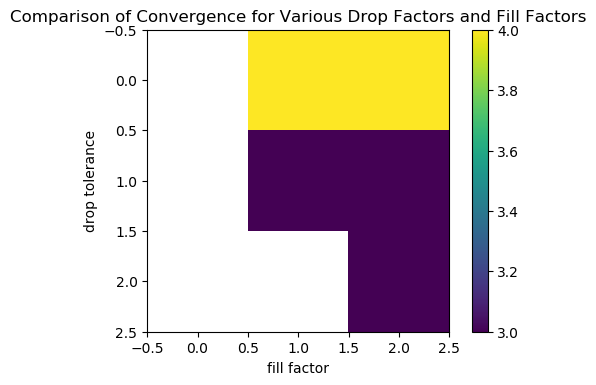

In [17]:
def study_ilu_convergence(h, tau, drop_tol_list, fill_fact_list):
    """
    For a system of size h, apply Scipy's ILU rountine
    for various drop factors and compare the rates of convergence for each
    run.
    """
    At, At2, At2LOP, bounds = build_CN_system(tau, h)
    b = np.ones(At2.shape[0])
    convergences = np.zeros((len(drop_tol_list), len(fill_fact_list)))
    for i, dt in enumerate(drop_tol_list):
        for j, ff in enumerate(fill_fact_list):
            P = create_preconditioner(At2, dt, ff)
            sol, history = faster_inversion_solve(At2, b, P, maxiter=200)
            convergences[i, j] = len(history)
    
    convergences[convergences==200]=np.nan
    plt.imshow(convergences)

    plt.xlabel('fill factor')
    plt.ylabel('drop tolerance')
    plt.title('Comparison of Convergence for Various Drop Factors and Fill Factors')
#     plt.legend(loc='upper right')
    plt.colorbar()
    fig = plt.gcf()
    fig.dpi = 100
    plt.show()

droptols = 10**np.linspace(-4, -5, 3)
fill_factors = np.linspace(15, 20, 3)
print(['%4E'%dt for dt in droptols])
print([ff for ff in fill_factors])
study_ilu_convergence(5e-3, 5e-3, droptols, fill_factors)

## Create Linear Operater in OpenCL

In [1]:
import pyopencl as cl
from scipy.sparse.linalg import LinearOperator
import numpy as np

def bytesize(N, dtype_str):
    """
    Returns the number of bytes that an array of element
    size N occupies
    """
    return np.dtype(dtype_str).itemsize*N

#### From Assignment 2

In [ ]:
class FivePointStencil(LinearOperator):
    """
    Created in reference to the PyLops Linear Operator tutorial.
    """
    kernel_code = """
    
    """
    def __init__(self, M, data_type=np.float64):
        """
        Set up the subclass with the shape of the matrix, the sparse matrix,
        and its data type. This initialiser sets the key parameters for
        the definition of a subclass of the LinearOperator class.
        """
        # Setup parameters required for parent class
        self.shape = (M**2, M**2)
        self.dtype =  np.dtype(data_type)
        self.explicit = False
        stepsize = 1/(M+1)
        # Create the OpenCL tool
        self.openCL_matvec = build_5point_kernel(M, stepsize)

    def _matvec(self, x):
        """
        Apply the initialised operator to the given vector.
        """
        return self.openCL_matvec(x)


def build_5point_kernel(M, stepsize):
    """
    Create the OpenCL kernel that evaluates the 5 point stencil
    for the given side number of points M on the unit square.
    """
    offset = 0 # Used to set offset in Buffers
    M_op = (M)**2 # This is the number of points in the lattice
    row_lookup = np.array([k//(M) for k in range(M_op)], dtype=np.int64)
    col_lookup = np.array([ k%(M) for k in range(M_op)], dtype=np.int64)
    # OpenCL C-Language Kernel
    # This implements the 5-point stencil approximation on a single point,
    # defined by its row and column coordinates.
    kernel = """
        __kernel void matvec(
            __global double *vector,
            __global double *result,
            __global long *row_lookup,
            __global long *col_lookup,
            double h,
            int N
        )
        {        
        // Get Global Identifiers i.e. the row index
        int row_index = get_global_id(0);
    
        int ref = row_index;
        
        // Exract reference coorindates
        int i = row_lookup[ref];
        int j = col_lookup[ref];
        
        // Determine boolean operators.
        // These decide if a particular term is active or not.
        int b1 = (int) (i != 0);
        int b2 = (int) (i != N-1);
        int b3 = (int) (j != 0);
        int b4 = (int) (j != N-1);
        
        double estimate = 1./(h*h) * (4*vector[row_index]
            - b1*vector[row_index-b1*N]
            - b2*vector[row_index+b2*N]
            - b3*vector[row_index-1]
            - b4*vector[row_index+1]
        );
        
        // Output answer
        result[row_index] = estimate;
        
        }
    """
    # Initialise the OpenCL environment
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    
    # Create the buffer to hold the vector data
    vector_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(M_op, 'double'))
    
    
# MAPPING
#     mapped_vector_buffer, linking_event = cl.enqueue_map_buffer(
#         queue, vector_buffer, cl.map_flags.WRITE, 0, M_op, np.dtype('double'))
#     linking_event.wait()

    
    # Create buffer to hold the result
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, size=bytesize(M_op, 'double'))
    # Map the buffer to a host object
#     mapped_result, linking_event = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ,
#         offset, M_op, np.double) 
#     linking_event.wait()                                   

    # Create buffers to hold row and column lookup arrays
    row_lookup_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=row_lookup)
    col_lookup_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=col_lookup)
    
    # Build the Kernel
    prg = cl.Program(ctx, kernel)
    prg.build()
    matvec_kernel = prg.matvec
    
    # Define what to be executed when matvec is called
    def exec_kernel(x):        
        # Rewrite vector buffer
        mapped_vector_buffer, linking_event = cl.enqueue_map_buffer(
            queue, vector_buffer, cl.map_flags.WRITE, offset, M_op, np.double)
        linking_event.wait()
        with mapped_vector_buffer.base:
            mapped_vector_buffer[:] = x    
            

        # Run the kernel
        matvec_kernel(
            # Workspace parameters
            queue, (M_op, ), (1, ),
            # Buffers
            vector_buffer, result_buffer, row_lookup_buffer, col_lookup_buffer, 
            np.float64(stepsize), np.int32(M)
        )
                
        mapped_result, event_linking = cl.enqueue_map_buffer(queue, result_buffer, cl.map_flags.READ,
                                      offset, M_op, np.double)
        event_linking.wait()
        
        with mapped_result.base:
            fetched_result = mapped_result
        
        queue.finish()
        
        return fetched_result
    # Pass the kernel executor to the class
    return exec_kernel

### From Assignement 3

In [ ]:
def create_preconditioner(A, dt):
    """
    Using SPILU and a specified drop tolerance, create a preconditioner
    for A.
    """
    ilu = spilu(A, drop_tol=dt)
    Mx = lambda x: ilu.solve(x)
    N = A.shape[0]
    P = LinearOperator((N, N), Mx)
    return P

In [29]:
not 0

True

In [48]:
a = True
b = [1, 2]
b[a]

2